# Lasing in the deep-strong coupling regime of quantum electrodynamics

The purpose of this notebook is to calculate the quantum state of a DSC system pumped by an inverted (gain) medium. This notebook implements the analytical theory described in the main text and in the supplement of arXiv:2111.07010. Spectra, eigenstates, and various observables for the DSC (or DSC+emitter) system are computed using the QuantumOptics.jl package in Julia (see https://qojulia.org/ for documentation and examples). Note that this is in Julia 1.1 and so some functions may have changed if you use the newest version.

In a second notebook, also in this repository, we calculate the steady states of the exact Hamiltonian of a DSC system coupled to an external pumped emitter (representing the gain), to show that approximations to Fock states are realized above threshold; in agreement with the analytics presented in this notebook.

In [1]:
using LinearAlgebra
using QuantumOptics
using SparseArrays
using Arpack
using PyPlot
using GSL

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10;
rcParams["font.sans-serif"] = "Arial";
rcParams["axes.labelsize"] = 10;
rcParams["xtick.labelsize"] = 10;
rcParams["ytick.labelsize"] = 10;
rcParams["legend.fontsize"] = 10;
rcParams["text.usetex"] = "False";
rcParams["svg.fonttype"] = "none";

In these cells, we calculate the spectrum of the Rabi model as well as energy differences between adjacent states. This leads to the plots in Fig. 1 of the main text. Feel free to adjust various parameters, such as the emitter-cavity detuning to see the influence on the spectrum.

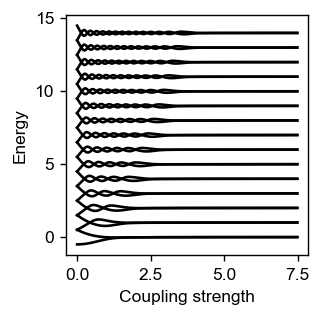

PyObject Text(27.500000000000007, 0.5, 'Energy')

In [3]:
## Parameters for the DSC Hamiltonian and the emitter coupling

# Rabi parameters (atom frequency, cavity frequency, coupling, sigma-x term strength)
ωa = 1;
ωc = 1;
g = 5;
δ = 0.0;

# Fock space cutoff
N_cutoff = 250;

## Set up bases and operators for emitter, atom, and photon

b_atom = SpinBasis(1//2);
b_fock = FockBasis(N_cutoff);

b_rabi = b_atom ⊗ b_fock;

σxa = sigmax(b_atom);
σya = sigmay(b_atom);
σza = sigmaz(b_atom);
σpa = sigmap(b_atom);
σma = sigmam(b_atom);
Ia = identityoperator(b_atom);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

## (Generalized) Rabi Hamiltonian and spectrum

H_rabi = ωa/2*(σza ⊗ Ip) + δ/2*(σxa ⊗ Ip) + ωc*(Ia ⊗ n) + g*(σxa ⊗ (a+ad));
eigvals_rabi, eigstates_rabi = eigenstates(dense(H_rabi));

g_vals = [0:0.01:10;]
num_g = size(g_vals,1);
n_eig_max = 30;
spectrum_g = zeros(n_eig_max,num_g);

for ii=1:num_g
    g = g_vals[ii];
    H_rabi = ωa/2*(σza ⊗ Ip) + δ/2*(σxa ⊗ Ip) + ωc*(Ia ⊗ n) + g*(σxa ⊗ (a+ad));
    eigvals_rabi, eigstates_rabi = eigenstates(dense(H_rabi));
    spectrum_g[:,ii] = eigvals_rabi[1:n_eig_max] .+ g^2;
end

g_vals = [0:0.01:10;]
figure(dpi=125,figsize=(2.5,2.5));
for ii=1:30
   plot(g_vals[1:750],spectrum_g[ii,1:750],color="black") 
end
xlabel("Coupling strength")
ylabel("Energy")

Note that the splittings plotted are calculated according to the analytical approximation. I encourage you to compare them against the spectrum computed by diagonalizing the Hamiltonian. You should find that they line up especially well for $n \lesssim n_c \sim g^2$. 

In [4]:
maxval = 100;
g_vals = [0:0.01:10;];
num_g = size(g_vals,1);
splitting = zeros(maxval,num_g);

for jj=1:num_g
    g = g_vals[jj]
    for ii=1:maxval
        splitting[ii,jj] = 1 + 0.5*exp(-2*g^2)*(sf_laguerre_n(ii,0,4*g^2)-sf_laguerre_n(ii-1,0,4*g^2));
    end
end

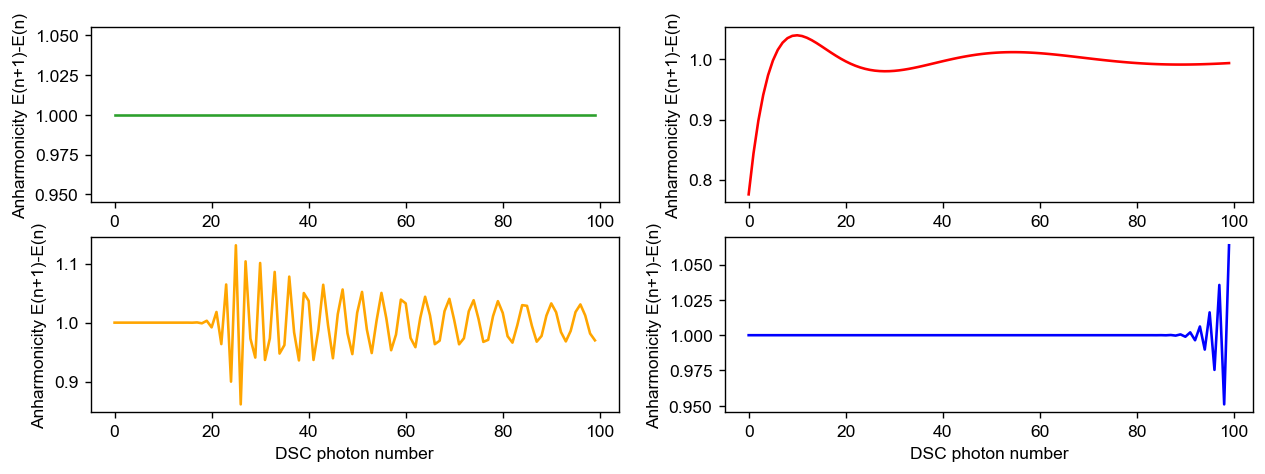

PyObject Text(661.6690340909089, 0.5, 'Anharmonicity E(n+1)-E(n)')

In [5]:
figure(dpi=125,figsize=(12,4));

subplot(2,2,1)
plot(splitting[1:100,1],linestyle="-",color="C2")
xlabel("DSC photon number")
ylabel("Anharmonicity E(n+1)-E(n)")

subplot(2,2,2)
plot(splitting[1:100,40],linestyle="-",color="red")
xlabel("DSC photon number")
ylabel("Anharmonicity E(n+1)-E(n)")

subplot(2,2,3)
plot(splitting[1:100,500],linestyle="-",color="orange")
xlabel("DSC photon number")
ylabel("Anharmonicity E(n+1)-E(n)")

subplot(2,2,4)
plot(splitting[1:100,1000],linestyle="-",color="blue")
xlabel("DSC photon number")
ylabel("Anharmonicity E(n+1)-E(n)")

The next cells here are related to coupling an external emitter to these DSC photons. Here, we calculate the available gain, according to the expressions below Eq. (5) of the manuscript. It is also plotted against the loss, approximated as $\kappa_n \approx \kappa n$, which works well until $n \sim n_c$. Around $n_c$ there are small changes to $\kappa_n$ that do not significantly change the results (as also verified in the second notebook which makes no analytical approximations).

In [6]:
function G(m,g,ϵ,Γ,δ)
    ξ = 4*g^2;
    G = (4*m*ϵ^2 + ωa^2*(δ - 0.5*exp(-ξ/2)*(sf_laguerre_n(m,0,ξ)-sf_laguerre_n(m-1,0,ξ)))^2)/Γ^2
    return G
end

function denom_ratio(m,g,ϵ,Γ,δ)
    val = (1+G(m,g,ϵ,Γ,δ));
    return val;
end

function dsc_gain_loss_analytical(α,g,ϵ,κ,Γ,δ,nmax)
    n_tab = [1:1:nmax;]  
    gain_tab = α*n_tab./(denom_ratio.(n_tab,g,ϵ,Γ,δ));
    loss_tab = n_tab;
    return n_tab, gain_tab, loss_tab
end

nvals0, gain0, loss0 = dsc_gain_loss_analytical(1.5,1e-3,1e-5,1e-4,1e-3,0,1500);
nvals1, gain1, loss1 = dsc_gain_loss_analytical(1.5,5,1e-5,1e-4,1e-3,0,200);
nvals2, gain2, loss2 = dsc_gain_loss_analytical(1.5,10,1e-5,1e-4,1e-3,0,200);
nvals3, gain3, loss3 = dsc_gain_loss_analytical(1.5,18,1e-5,1e-4,1e-3,0,400);

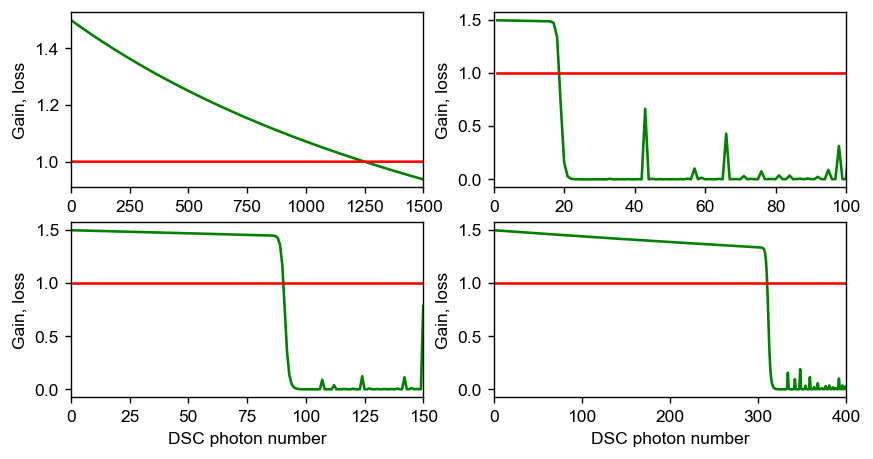

PyObject Text(450.22727272727263, 0.5, 'Gain, loss')

In [7]:
figure(dpi=125,figsize=(8,4));
subplot(2,2,1)
plot(nvals0,gain0 ./ nvals0,linestyle="-",color="g")
plot(nvals0,loss0 ./ nvals0,linestyle="-",color="r")
xlim(0,1500)
xlabel("DSC photon number")
ylabel("Gain, loss")

subplot(2,2,2)
plot(nvals1,gain1 ./ nvals1,linestyle="-",color="g")
plot(nvals1,loss1 ./ nvals1,linestyle="-",color="r")
xlim(0,100)
xlabel("DSC photon number")
ylabel("Gain, loss")

subplot(2,2,3)
plot(nvals2,gain2 ./ nvals2,linestyle="-",color="g")
plot(nvals2,loss2 ./ nvals2,linestyle="-",color="r")
xlim(0,150)
xlabel("DSC photon number")
ylabel("Gain, loss")

subplot(2,2,4)
plot(nvals3,gain3 ./ nvals3,linestyle="-",color="g")
plot(nvals3,loss3 ./ nvals3,linestyle="-",color="r")
xlim(0,400)
xlabel("DSC photon number")
ylabel("Gain, loss")

These next cells compute the steady state probability distribution to find $n$ DSC photons, according to the analytical solution for the steady-state density matrix (given by $p_n = Z^{-1}\prod\limits_{m=1}^n R_m/\kappa_m$ as described in the main text). We then plot the laser "S-curve" or "input-output curve" (mean DSC photon number as a function of pump rate above threshold) and the fluctuations (variance in DSC photon number in steady state) for a few different couplings, reproducing the right-side Fig. 2 of the main text. We also plot steady-state distributions as a function of pump, showing the evolution from thermality to Fock-like behavior.

In [8]:
function rth(ϵ,κ,Γ)
    r_th = κ*Γ^2/(2*ϵ^2);
    return r_th
end

function gainloss(r,ϵ,κ,Γ)
    r_th = rth(ϵ,κ,Γ);
    a_over_c = r/r_th;
    return a_over_c
end


function photon_dist(r,g,ϵ,κ,Γ,nmax)
    n_tab = [1:1:nmax;]
    a_over_c = gainloss(r,ϵ,κ,Γ);
    gain_tab = a_over_c*ones(nmax);
    nl_tab = denom_ratio.(n_tab,g,ϵ,Γ,δ);
    gain_cumul = cumprod(gain_tab);
    nl_cumul = cumprod(nl_tab);
    gain_nl_cumul = cumprod(gain_tab./nl_tab);
    ρ_ph = [1; gain_nl_cumul];
    ρ_ph = ρ_ph/sum(ρ_ph);
    return ρ_ph
end

function photon_stats(ρ_ph)
    n_vals = [0:1:nmax;];
    nexp = sum(n_vals.*ρ_ph);
    n2exp = sum((n_vals.^2).*ρ_ph);
    deltan2 = n2exp - (nexp)^2;
    deltan = sqrt(deltan2);
    mandel = deltan2/nexp - 1;
    return nexp, n2exp, deltan, mandel
end

photon_stats (generic function with 1 method)

In [9]:
ϵ = 1e-5;
Γ = 1e-3;
κ = 1e-4;

nmax = 2500;

r_th = rth(ϵ,κ,Γ);
r_vals = [0.5:0.02:1.94;]*r_th;;
g_vals = [0.0001 0.1 0.5 1 3 5 10 18];

num_r = size(r_vals,1);
num_g = size(g_vals,2);

Prg = zeros(num_g,num_r);
dnrg = zeros(num_g,num_r);
mandelrg = zeros(num_g,num_r);

for ii=1:num_g
    g = g_vals[ii];
    for jj=1:num_r
        r = r_vals[jj];
        ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
        nexp, n2exp, deltan, mandel = photon_stats(ρph);
        Prg[ii,jj] = nexp;
        dnrg[ii,jj] = deltan;
        mandelrg[ii,jj] = mandel;
    end
end

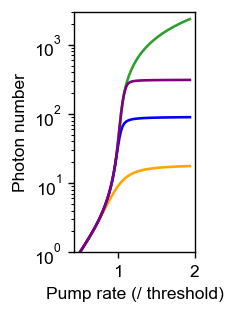

(1, 3000.0)

In [10]:
figure(dpi=125,figsize=(1.25,2.5));
semilogy(r_vals/r_th,Prg[1,:],linestyle="-",color="C2")
semilogy(r_vals/r_th,Prg[6,:],linestyle="-",color="orange")
semilogy(r_vals/r_th,Prg[7,:],linestyle="-",color="blue")
semilogy(r_vals/r_th,Prg[8,:],linestyle="-",color="purple")
xlabel("Pump rate (/ threshold)")
ylabel("Photon number")
ylim(1,3e3)

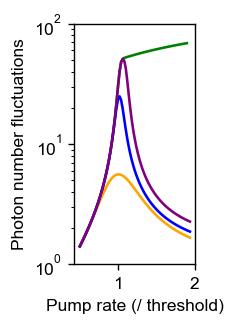

(1, 100.0)

In [11]:
figure(dpi=125,figsize=(1.25,2.5));
semilogy(r_vals[1:end-2]/r_th,dnrg[1,1:end-2],linestyle="-",color="green")
semilogy(r_vals/r_th,dnrg[6,:],linestyle="-",color="orange")
semilogy(r_vals/r_th,dnrg[7,:],linestyle="-",color="blue")
semilogy(r_vals/r_th,dnrg[8,:],linestyle="-",color="purple")
xlabel("Pump rate (/ threshold)")
ylabel("Photon number fluctuations")
ylim(1,1e2)

Steady-state probability distributions as a function of pump for different couplings $g$.

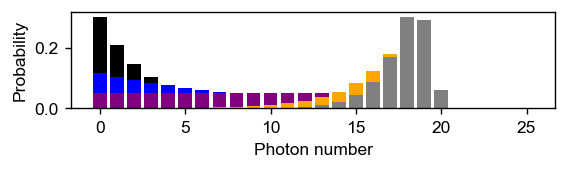

PyObject Text(27.578124999999993, 0.5, 'Probability')

In [12]:
ϵ = 1e-5;
Γ = 1e-3;
κ = 1e-4;

g = 5;

nmax = 25;

r_th = rth(ϵ,κ,Γ);
r_vals = [0.7; 0.9; 1.0025; 1.5; 2]*r_th;;
n_vals = [0:1:nmax;];

num_r = size(r_vals,1);

ρnr = zeros(num_r,size(n_vals,1));

for ii=1:num_r
    r = r_vals[ii];
    ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
    ρnr[ii,:] = ρph;
end

figure(dpi=125,figsize=(5,1));
color_vec = ["black","blue","purple","orange","gray"]
for ii=1:num_r
    bar(n_vals,ρnr[ii,:],color=color_vec[ii])
end
xlabel("Photon number")
ylabel("Probability")

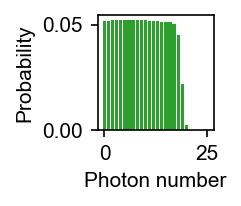

PyObject Text(34.00000000000001, 0.5, 'Probability')

In [13]:
figure(dpi=150,figsize=(1,1));
bar(n_vals,ρnr[3,:],color="C2")
xlabel("Photon number")
ylabel("Probability")

Above we also plot the near-threshold state at 0.25% above threshold, which clearly looks like a uniform distribution.

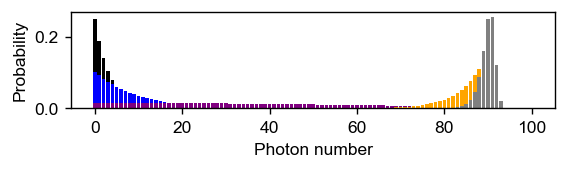

PyObject Text(27.578124999999993, 0.5, 'Probability')

In [14]:
ϵ = 1e-5;
Γ = 1e-3;
κ = 1e-4;

g = 10;

nmax = 100;

r_th = rth(ϵ,κ,Γ);
r_vals = [0.75; 0.9; 1.005; 1.25; 2;]*r_th;
n_vals = [0:1:nmax;];

num_r = size(r_vals,1);

ρnr = zeros(num_r,size(n_vals,1));

for ii=1:num_r
    r = r_vals[ii];
    ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
    ρnr[ii,:] = ρph;
end

figure(dpi=125,figsize=(5,1));
color_vec = ["black","blue","purple","orange","gray"]
for ii=1:num_r
    bar(n_vals,ρnr[ii,:],color=color_vec[ii])
end
xlabel("Photon number")
ylabel("Probability")

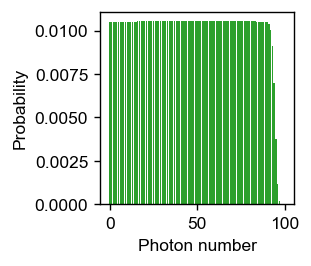

PyObject Text(27.578125000000014, 0.5, 'Probability')

In [15]:
ϵ = 1e-5;
Γ = 1e-2;
κ = 1e-4;

g = 10;

nmax = 100;

r_th = rth(ϵ,κ,Γ);
r_vals = [1.0002;]*r_th;
n_vals = [0:1:nmax;];

num_r = size(r_vals,1);

ρnr = zeros(num_r,size(n_vals,1));

for ii=1:num_r
    r = r_vals[ii];
    ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
    ρnr[ii,:] = ρph;
end

figure(dpi=125,figsize=(2,2));
bar(n_vals,ρnr[1,:],color="C2")
xlabel("Photon number")
ylabel("Probability")

Above we change parameters (increasing the gain bandwidth) and also show the uniform state of Fig. 3.

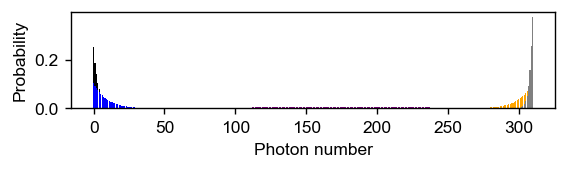

PyObject Text(27.578124999999993, 0.5, 'Probability')

In [16]:
ϵ = 1e-5;
Γ = 1e-3;
κ = 1e-4;

g = 18;

nmax = 310;

r_th = rth(ϵ,κ,Γ);
r_vals = [0.75; 0.9; 1.07; 1.25; 2;]*r_th;
n_vals = [0:1:nmax;];

num_r = size(r_vals,1);

ρnr = zeros(num_r,size(n_vals,1));

for ii=1:num_r
    r = r_vals[ii];
    ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
    ρnr[ii,:] = ρph;
end

figure(dpi=125,figsize=(5,1));
color_vec = ["black","blue","purple","orange","gray"]
for ii=1:num_r
    bar(n_vals,ρnr[ii,:],color=color_vec[ii])#/maximum(ρnr[ii,:]))
end
xlabel("Photon number")
ylabel("Probability")

The cells below show what happen when the bandwidth of the gain changes. In that case, even though the anharmonicity is strong near $n_c$, the gain is broad enough to allow some transitions to higher energies, allowing the steady-state distribution to go to higher photon numbers than $n_c$.

In [17]:
ϵ = 1e-3;
Γ = 1e-1;
κ = 1e-4;

g = 10;

nmax = 1000;

r_th = rth(ϵ,κ,Γ);
r_vals = [1.1; 1.14; 1.15; 1.2;]*r_th;;
n_vals = [0:1:nmax;];

num_r = size(r_vals,1);

ρnr = zeros(num_r,size(n_vals,1));

for ii=1:num_r
    r = r_vals[ii];
    ρph = photon_dist(r,g,ϵ,κ,Γ,nmax);
    ρnr[ii,:] = ρph;
end

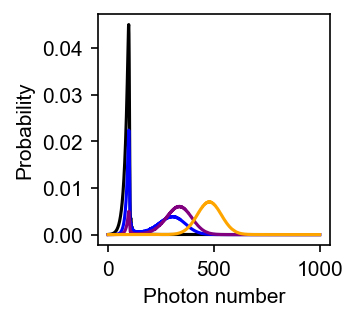

PyObject Text(34.00000000000002, 0.5, 'Probability')

In [18]:
figure(dpi=150,figsize=(2,2));
for ii=1:num_r
    plot(n_vals,ρnr[ii,:],color=color_vec[ii])
end
color_vec = ["black","blue","purple","orange","gray"]
xlabel("Photon number")
ylabel("Probability")